# 18.065 project: comparison result

In [1]:
#import sys
#!{sys.executable} -m pip install tf-nightly

In [2]:
import sklearn
import numpy as np
from sklearn.datasets import load_iris,make_swiss_roll,fetch_lfw_people
from  sklearn.model_selection import train_test_split
# Custom train/test wrappers for sklearn models
from sklearn_wrappers import *
import pickle
import matplotlib.pyplot as plt

In [3]:
# more readable visuals 
#large = 22; med = 16; small = 10
#params = {'axes.titlesize': large,
#          'legend.fontsize': med,
#          'figure.figsize': (16, 10),
#          'axes.labelsize': med,
#          'axes.titlesize': med,
#          'axes.linewidth': 2,
#          'xtick.labelsize': med,
#          'ytick.labelsize': med,
#          'figure.titlesize': large}
#plt.style.use('seaborn-white')
#plt.rcParams.update(params)
#%matplotlib inline

## Test sweep code

In [4]:
def run_test_sweep(num_dataset_dims, X_train, X_test, is_faces, dataset_name, fn_prefix="results_", h=None, w=None, skip_spca_for_faces=False, no_sigmoid=False):
    
    # h and w must be specified if this is a faces dataset
    assert(not (is_faces and (h is None or w is None)))        
    
    res={}
    k_iters=[]
    model_iters=[]
    data_iters=[]
    hparam_iters=[]
    loss_iters=[]
    
    k_vals=[]
    
    if num_dataset_dims<10:
        k_vals=range(1,num_dataset_dims+1)
    else:
        #k_vals=[1,2,3,4,5,6,7,8]
        k_vals=np.linspace(start=1, stop=num_dataset_dims, num=8)
    
    for k_prim in k_vals:
        k=int(k_prim)
        print("Number of components: k =",k)
        
        # SPCA
        best_spca_alpha=[]
        best_spca_alpha_err=[]
        if is_faces:
            if skip_spca_for_faces:
                best_spca_alpha=None
                best_spca_alpha_err=0.0
            else:
                best_spca_alpha, best_spca_alpha_err, _ = spca_exp_faces(X_train,X_test,k,h,w)                
        else:
            best_spca_alpha, best_spca_alpha_err = spca_exp(X_train,X_test,k)
        k_iters.append(k)
        model_iters.append("spca")
        data_iters.append(dataset_name)
        hparam_iters.append({"alpha":best_spca_alpha})
        loss_iters.append(best_spca_alpha_err)
        
        # KPCA
        best_kernel, best_kernel_err = kernel_exp(X_train,X_test,k,no_sigmoid=no_sigmoid)
        k_iters.append(k)
        model_iters.append("kpca")
        data_iters.append(dataset_name)
        hparam_iters.append({"kernel":best_kernel})
        loss_iters.append(best_kernel_err)        
        
        # Autoencoder
        _, best_autoencoder_err = autoencoder_exp(X_train, X_test, k)
        k_iters.append(k)
        model_iters.append("autoencoder")
        data_iters.append(dataset_name)
        hparam_iters.append({})
        loss_iters.append(best_autoencoder_err)                
        
        # NMF
        best_nmf_err=[]
        if is_faces:
            _, best_nmf_err, _ = nmf_exp_faces(X_train,X_test,k,h,w)
        else:
            _, best_nmf_err = nmf_exp(X_train,X_test,k)
        k_iters.append(k)
        model_iters.append("nmf")
        data_iters.append(dataset_name)
        hparam_iters.append({})
        loss_iters.append(best_nmf_err)              
        
        # ==> Summary
        print("- MSE loss summary: ",dataset_name,"is_faces =",is_faces,"k =",k)
        print("-- Sparse PCA (alpha=",best_spca_alpha,"): err=",best_spca_alpha_err)
        print("-- Kernel PCA(",best_kernel,"): err=",best_kernel_err)
        print("-- Autoencoder: err=",best_autoencoder_err)
        print("-- NMF: err=",best_nmf_err)
        
        
    res["k_iters"]=k_iters
    res["model_iters"]=model_iters
    res["data_iters"]=data_iters
    res["hparam_iters"]=hparam_iters
    res["loss_iters"]=loss_iters
    
    fn=fn_prefix+dataset_name+".p"
    print("\n\nSaving results to",fn,"...")    
    with open(fn,"wb") as fp:
        pickle.dump(res, fp)
    print("- Done.")
    
    return res

In [5]:
def res_query(res,model=None):
    k_iters=[]
    loss_iters=[]
    
    for idx in range(len(res["k_iters"])):
        if res["model_iters"][idx]==model:
            k_iters.append(res["k_iters"][idx])
            loss_iters.append(res["loss_iters"][idx])
    
    return k_iters,loss_iters

## Iris dataset: Sparse PCA, Kernel PCA, autoencoder, NMF (TODO); MSE, Frobenius (TODO)

In [6]:
# load Iris dataset
iris = load_iris()
X = iris.data # predictor
y = iris.target #response
num_dataset_dims=4
dataset_name="iris"
print('The predictor variable shape: ', X.shape)
print('The response variable shape: ', y.shape)
print('The number of dataset dimensions: ',num_dataset_dims)

# Standardize the data
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

The predictor variable shape:  (150, 4)
The response variable shape:  (150,)
The number of dataset dimensions:  4


Number of components: k = 1
alpha= 0.001 err= 0.08444980228677237
alpha= 0.002 err= 0.08444839106270502
alpha= 0.005 err= 0.08444416117840108
alpha= 0.01 err= 0.08443683382672176
alpha= 0.02 err= 0.08442252647896613
alpha= 0.05 err= 0.0843796398540697
alpha= 0.1 err= 0.08430980337873432
alpha= 0.2 err= 0.08417665024787133
alpha= 0.5 err= 0.08383649597563905
alpha= 1.0 err= 0.0835327070382529
alpha= 2.0 err= 0.08473597418229313
alpha= 5.0 err= 0.09565845900298281


Best SPCA:
- alpha: 1.0
- err: 0.0835327070382529
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.0844847822746608
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.21469232592138096
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 1.0162541892445829


Best MSE reconstruction error: 0.0844847822746608
- Kernel: Linear kernel
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape         

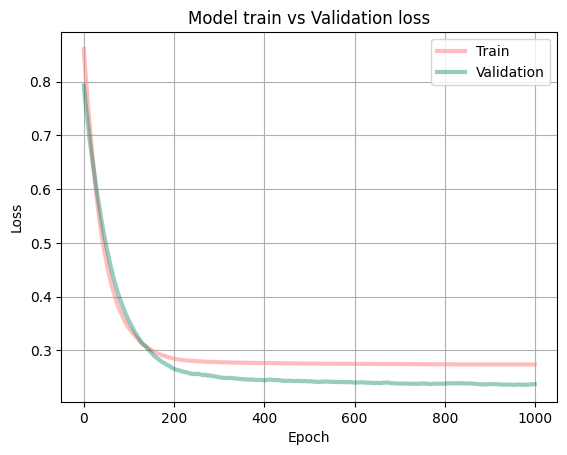

Training loss: 0.27389079332351685
Validation loss: 0.2372332364320755
MSE on training data: 0.09839331057236313
MSE on test data: 0.08371648413748568


Best NMF:
Basis vectors:
 [[1.18558032 0.913377   1.33057414 1.32708452]]
Coefficients:
 [[0.22385812]
 [0.12539011]
 [0.09026505]
 [0.23582576]
 [0.35726372]
 [0.4758492 ]
 [0.38173096]
 [0.16974067]
 [0.40543153]
 [0.21020557]
 [0.23487284]
 [0.3162771 ]
 [0.16888551]
 [0.51891248]
 [0.18444978]
 [0.35009302]
 [0.44708433]
 [0.45458983]
 [0.42309497]
 [0.55352549]
 [0.73663061]
 [0.30336664]
 [0.20937183]
 [0.4839197 ]
 [0.65152678]
 [0.4725299 ]
 [0.67001248]
 [0.34777196]
 [0.41168263]
 [0.62192153]
 [0.46441434]
 [0.60050471]
 [0.46844377]
 [0.09295176]
 [0.17066163]
 [0.4006249 ]
 [0.54394471]
 [0.23671382]
 [0.44622985]
 [0.60958824]
 [0.67489571]
 [0.2282554 ]
 [0.15387588]
 [0.39960412]
 [0.1920204 ]
 [0.50742092]
 [0.71715883]
 [0.20398804]
 [0.24509658]
 [0.57605032]
 [0.32045156]
 [0.66468233]
 [0.33538323]
 [0.28642769]
 [

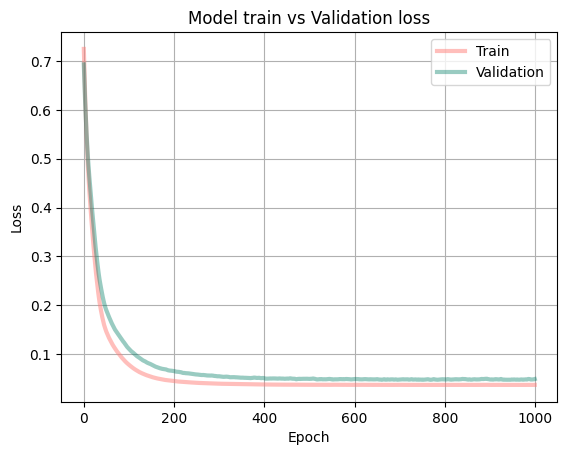

Training loss: 0.03706064075231552
Validation loss: 0.04893536493182182
MSE on training data: 0.033693683630367954
MSE on test data: 0.041988732945888875


Best NMF:
Basis vectors:
 [[0.82137556 0.07780183 1.12032218 1.12846419]
 [0.19895453 0.74626487 0.01140546 0.        ]]
Coefficients:
 [[0.32952816 0.        ]
 [0.05031346 0.55845463]
 [0.02007459 0.47188552]
 [0.31304371 0.10555654]
 [0.47906655 0.1391285 ]
 [0.63230103 0.21018511]
 [0.51114443 0.15163881]
 [0.05156322 0.82758345]
 [0.48662464 0.40440473]
 [0.11501969 0.80358848]
 [0.06900751 1.15520398]
 [0.39851746 0.23373983]
 [0.05867103 0.79150772]
 [0.6720403  0.30494954]
 [0.08772853 0.76219068]
 [0.39897164 0.4411315 ]
 [0.56748801 0.3124831 ]
 [0.52595217 0.53856113]
 [0.49443137 0.47997093]
 [0.71194891 0.34646522]
 [0.83601404 0.94303425]
 [0.36290806 0.30785597]
 [0.02950674 1.1682566 ]
 [0.58351126 0.47120368]
 [0.83462634 0.42222331]
 [0.58982349 0.37339079]
 [0.83771901 0.52333305]
 [0.43003827 0.29233003]
 [0.4811

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


alpha= 0.001 err= 0.013684763344123798
alpha= 0.002 err= 0.013686208689456735
alpha= 0.005 err= 0.013670331320001186
alpha= 0.01 err= 0.013639326236472668
alpha= 0.02 err= 0.01367317286632334
alpha= 0.05 err= 0.013716171883684234
alpha= 0.1 err= 0.01377739251482688
alpha= 0.2 err= 0.013968265303509685
alpha= 0.5 err= 0.015200882744925587
alpha= 1.0 err= 0.018154948453484487
alpha= 2.0 err= 0.01856192368295794
alpha= 5.0 err= 0.018736824767198464


Best SPCA:
- alpha: 0.01
- err: 0.013639326236472668
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.013866425220427811
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.19038382772938334
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 1.0162525503980577


Best MSE reconstruction error: 0.013866425220427811
- Kernel: Linear kernel
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Par

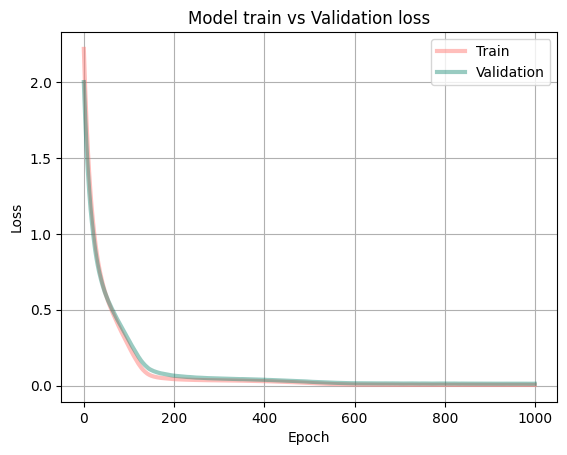

Training loss: 0.004131651483476162
Validation loss: 0.012012366205453873
MSE on training data: 0.011946865269119462
MSE on test data: 0.01495110630228783


Best NMF:
Basis vectors:
 [[0.34529424 0.         0.89282502 1.10247694]
 [0.6058801  0.15515278 0.25276389 0.        ]
 [0.09523483 0.77915707 0.         0.04159526]]
Coefficients:
 [[3.75459154e-01 1.35041422e-01 0.00000000e+00]
 [2.03265994e-02 1.87400591e-01 4.97221839e-01]
 [3.68698543e-02 0.00000000e+00 4.75382379e-01]
 [3.58796288e-01 1.23214926e-01 1.31457186e-01]
 [6.10700559e-01 0.00000000e+00 2.55454362e-01]
 [6.54943947e-01 4.93408301e-01 1.72568318e-01]
 [4.55098267e-01 6.56335872e-01 2.89743508e-02]
 [3.35572980e-02 1.65656708e-01 7.71687256e-01]
 [4.51912030e-01 5.76764064e-01 3.03815276e-01]
 [1.34164169e-01 9.07318978e-02 7.88949733e-01]
 [0.00000000e+00 4.73579790e-01 9.81077295e-01]
 [3.97253789e-01 3.71221950e-01 1.88388340e-01]
 [4.91212724e-03 2.93906362e-01 6.91432146e-01]
 [8.16383245e-01 1.11224649e-01 4.12

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


alpha= 0.001 err= 1.6978592930782212e-32
alpha= 0.002 err= 6.303872802181167e-32
alpha= 0.005 err= 1.9978989054669693e-32
alpha= 0.01 err= 5.85786797295465e-32
alpha= 0.02 err= 4.8361114550902644e-32
alpha= 0.05 err= 1.3278780142880415e-33
alpha= 0.1 err= 1.3278780142880415e-33
alpha= 0.2 err= 1.3278780142880415e-33
alpha= 0.5 err= 1.3278780142880415e-33
alpha= 1.0 err= 1.3278780142880415e-33
alpha= 2.0 err= 1.3278780142880415e-33
alpha= 5.0 err= 1.3278780142880415e-33


Best SPCA:
- alpha: 0.05
- err: 1.3278780142880415e-33
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.0015158158125290293
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.1884662042124495
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 1.0162525394650002


Best MSE reconstruction error: 0.0015158158125290293
- Kernel: Linear kernel
Model: "model_3"
_________________________________________________________________
 Layer (type)                Ou

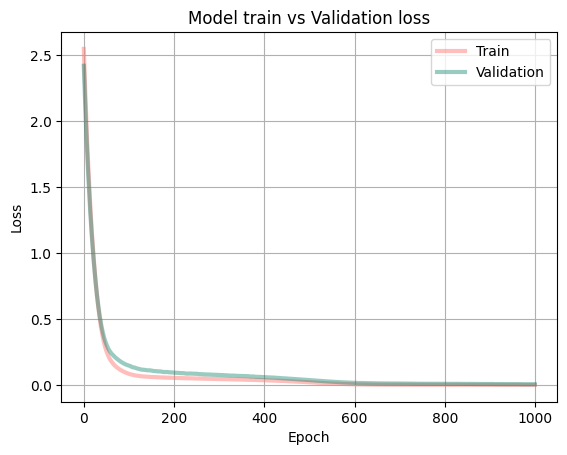

Training loss: 0.002624672371894121
Validation loss: 0.00793600082397461
MSE on training data: 0.008710576637009334
MSE on test data: 0.010380385332776782


Best NMF:
Basis vectors:
 [[0.47014226 0.         0.30528888 0.        ]
 [0.25599305 0.2241891  0.         0.04565955]
 [0.         0.69351807 0.         0.        ]
 [0.11190909 0.         0.47876803 0.60860783]]
Coefficients:
 [[2.94780068e-01 0.00000000e+00 0.00000000e+00 6.44033392e-01]
 [1.54809456e-01 3.48360057e-01 4.88228031e-01 4.25346724e-02]
 [5.59210149e-02 0.00000000e+00 5.40881669e-01 8.13607315e-02]
 [2.74419012e-01 0.00000000e+00 1.80293890e-01 6.24142183e-01]
 [1.16884632e-01 0.00000000e+00 3.00489816e-01 1.11929147e+00]
 [3.98526741e-01 9.28622331e-01 0.00000000e+00 1.16247557e+00]
 [6.82262740e-01 5.69470028e-01 0.00000000e+00 7.75309876e-01]
 [2.94991127e-02 6.67573446e-01 6.85399973e-01 8.70720843e-02]
 [8.74998258e-01 1.63826010e-02 4.75481248e-01 7.51855374e-01]
 [0.00000000e+00 6.58238777e-01 6.88421269e-01

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [7]:
# Run Iris test sweep
res=run_test_sweep(num_dataset_dims, X_train, X_test, is_faces=False, dataset_name=dataset_name)

Filename: results_iris.p


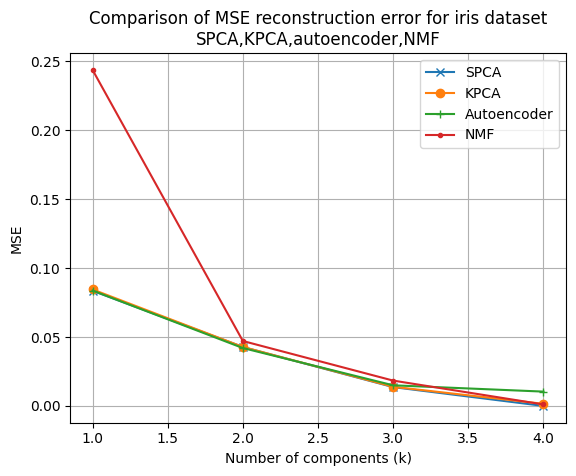

In [8]:
# Reload the test data which was just saved
fn_prefix="results_"
fn=fn_prefix+dataset_name+".p"
print("Filename:",fn)
res_loaded={}
with open(fn,"rb") as fp:
    res_loaded = pickle.load(fp)

k_spca,loss_spca=res_query(res_loaded,model="spca")
k_kpca,loss_kpca=res_query(res_loaded,model="kpca")
k_autoencoder,loss_autoencoder=res_query(res_loaded,model="autoencoder")
k_nmf,loss_nmf=res_query(res_loaded,model="nmf")

# Plot comparison
plt.plot(k_spca,loss_spca,"x-")
plt.plot(k_kpca,loss_kpca,"o-")
plt.plot(k_autoencoder,loss_autoencoder,"+-")
plt.plot(k_nmf,loss_nmf,".-")
plt.grid('on')
plt.xlabel('Number of components (k)')
plt.ylabel('MSE')
plt.title('Comparison of MSE reconstruction error for '+dataset_name+' dataset\nSPCA,KPCA,autoencoder,NMF')
plt.legend(["SPCA","KPCA","Autoencoder","NMF"])

## Swiss roll dataset: Sparse PCA, Kernel PCA, autoencoder

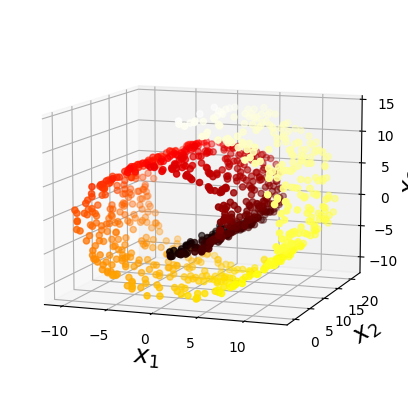

In [9]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
num_dataset_dims=3
dataset_name='swiss'
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, t, random_state=0)

Number of components: k = 1
alpha= 0.001 err= 25.88735199952893
alpha= 0.002 err= 25.887296954852236
alpha= 0.005 err= 25.887131825150686
alpha= 0.01 err= 25.88632498939963
alpha= 0.02 err= 25.884459938046504
alpha= 0.05 err= 25.878897851663936
alpha= 0.1 err= 25.869402574519928
alpha= 0.2 err= 25.850513159107553
alpha= 0.5 err= 25.79516859798495
alpha= 1.0 err= 25.732112171148717
alpha= 2.0 err= 25.844414308383776
alpha= 5.0 err= 25.84851733063986


Best SPCA:
- alpha: 1.0
- err: 25.732112171148717
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 25.88743089477897
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 26.488551619123673
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 43.129452081103466


Best MSE reconstruction error: 25.88743089477897
- Kernel: Linear kernel
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   

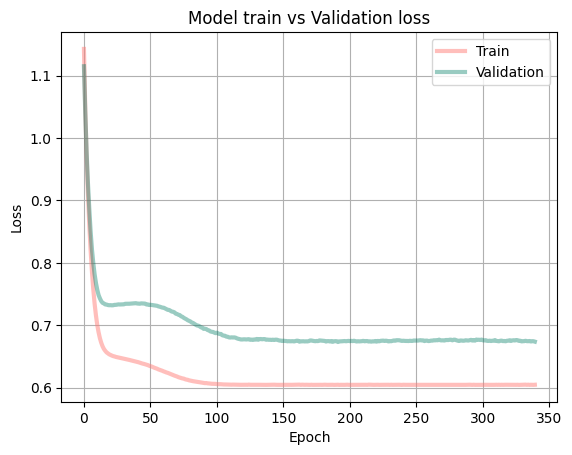

Training loss: 0.604727029800415
Validation loss: 0.6737797856330872
MSE on training data: 25.759332382224233
MSE on test data: 26.109610904209276


Best NMF:
Basis vectors:
 [[1.35552412 1.3121089  1.16037592]]
Coefficients:
 [[0.33621733]
 [0.54131577]
 [0.43200775]
 [0.14663136]
 [0.33426298]
 [0.23781846]
 [0.20756885]
 [0.26034577]
 [0.59622903]
 [0.16702168]
 [0.53128304]
 [0.40024337]
 [0.30950102]
 [0.6244482 ]
 [0.37648415]
 [0.36468586]
 [0.55468171]
 [0.59120473]
 [0.53555961]
 [0.33258238]
 [0.09032642]
 [0.30377968]
 [0.62685533]
 [0.18290088]
 [0.156763  ]
 [0.40450092]
 [0.34648825]
 [0.51490185]
 [0.38268035]
 [0.26967419]
 [0.26481562]
 [0.41653426]
 [0.23071608]
 [0.26652828]
 [0.4675146 ]
 [0.25524312]
 [0.55680574]
 [0.43971718]
 [0.17310678]
 [0.35352382]
 [0.51957352]
 [0.19206755]
 [0.25006619]
 [0.27285688]
 [0.33997424]
 [0.44699992]
 [0.42552969]
 [0.25359283]
 [0.18401585]
 [0.23953564]
 [0.38008783]
 [0.3235637 ]
 [0.20142523]
 [0.44780721]
 [0.27744133]
 [0

alpha= 0.002 err= 14.008930425807144
alpha= 0.005 err= 14.00894240514299
alpha= 0.01 err= 14.00850059074628
alpha= 0.02 err= 14.007879503461636
alpha= 0.05 err= 14.005698933105954
alpha= 0.1 err= 14.001563880452723
alpha= 0.2 err= 14.00156122445131
alpha= 0.5 err= 14.001474253033772
alpha= 1.0 err= 14.001475867293488
alpha= 2.0 err= 14.001378525778234
alpha= 5.0 err= 14.00426934023406


Best SPCA:
- alpha: 2.0
- err: 14.001378525778234
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 14.008913434830902
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 15.07805422417578
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 43.12636274479198


Best MSE reconstruction error: 14.008913434830902
- Kernel: Linear kernel
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0        

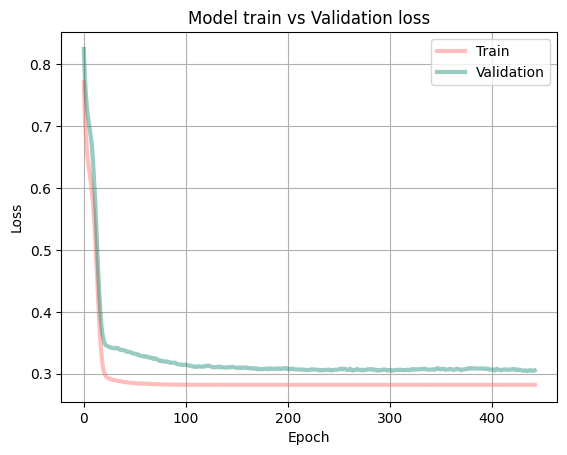

Training loss: 0.282050222158432
Validation loss: 0.3054118752479553
MSE on training data: 12.837088061421605
MSE on test data: 14.028907439229833


Best NMF:
Basis vectors:
 [[0.14323307 1.17312476 0.21806544]
 [0.69136705 0.00947141 0.53094816]]
Coefficients:
 [[0.10740367 0.91713164]
 [0.77668797 0.71054164]
 [0.41609648 0.82558309]
 ...
 [0.38552502 0.92337907]
 [0.74893094 0.048843  ]
 [0.1263542  1.29482953]]


Best MSE reconstruction error on train data: 13.081659082598614
Best MSE reconstruction error on test data: 14.192104831360645
- MSE loss summary:  swiss is_faces = False k = 2
-- Sparse PCA (alpha= 2.0 ): err= 14.001378525778234
-- Kernel PCA( Linear kernel ): err= 14.008913434830902
-- Autoencoder: err= 14.028907439229833
-- NMF: err= 14.192104831360645
Number of components: k = 3


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


alpha= 0.001 err= 3.0627355163370677e-30
alpha= 0.002 err= 6.090440934892324e-30
alpha= 0.005 err= 1.0491187519538588e-30
alpha= 0.01 err= 2.76293524635804e-30
alpha= 0.02 err= 1.3083622755826618e-30
alpha= 0.05 err= 3.0906989919669332e-30
alpha= 0.1 err= 6.23456905783851e-32
alpha= 0.2 err= 6.23456905783851e-32
alpha= 0.5 err= 6.23456905783851e-32
alpha= 1.0 err= 6.23456905783851e-32
alpha= 2.0 err= 6.23456905783851e-32
alpha= 5.0 err= 6.23456905783851e-32


Best SPCA:
- alpha: 0.1
- err: 6.23456905783851e-32
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 7.85736554600341e-05
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 1.7988413117510753
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 43.12321410407829


Best MSE reconstruction error: 7.85736554600341e-05
- Kernel: Linear kernel
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape        

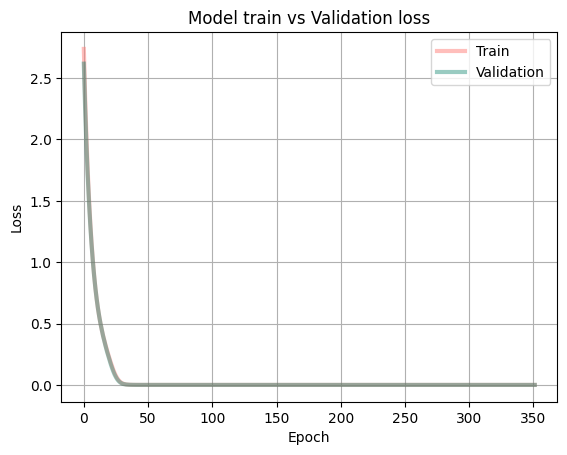

Training loss: 1.541051357703549e-13
Validation loss: 6.856763556462378e-14
MSE on training data: 3.2109960447112952e-12
MSE on test data: 3.263695145591581e-12


Best NMF:
Basis vectors:
 [[0.         0.73634949 0.00941795]
 [0.02473594 0.         0.6626627 ]
 [0.26417767 0.00827386 0.        ]]
Coefficients:
 [[0.13505742 1.11710353 1.68268753]
 [1.23375923 0.60742177 2.6084212 ]
 [0.62777833 1.11700428 1.65158108]
 ...
 [0.59174004 0.95317371 2.35376037]
 [1.19943798 0.07938475 0.89045694]
 [0.16660861 1.30275755 2.90011719]]


Best MSE reconstruction error on train data: 0.00023172285355753096
Best MSE reconstruction error on test data: 0.00010643906017002737
- MSE loss summary:  swiss is_faces = False k = 3
-- Sparse PCA (alpha= 0.1 ): err= 6.23456905783851e-32
-- Kernel PCA( Linear kernel ): err= 7.85736554600341e-05
-- Autoencoder: err= 3.263695145591581e-12
-- NMF: err= 0.00010643906017002737


Saving results to results_swiss.p ...
- Done.


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [10]:
# Run Swiss roll test sweep
res=run_test_sweep(num_dataset_dims, X_train, X_test, is_faces=False, dataset_name=dataset_name)

Filename: results_swiss.p


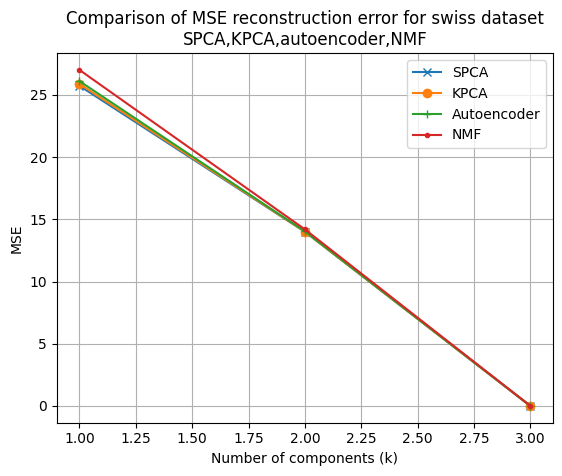

In [11]:
# Reload the test data which was just saved
fn_prefix="results_"
fn=fn_prefix+dataset_name+".p"
print("Filename:",fn)
res_loaded={}
with open(fn,"rb") as fp:
    res_loaded = pickle.load(fp)

k_spca,loss_spca=res_query(res_loaded,model="spca")
k_kpca,loss_kpca=res_query(res_loaded,model="kpca")
k_autoencoder,loss_autoencoder=res_query(res_loaded,model="autoencoder")
k_nmf,loss_nmf=res_query(res_loaded,model="nmf")

# Plot comparison
plt.plot(k_spca,loss_spca,"x-")
plt.plot(k_kpca,loss_kpca,"o-")
plt.plot(k_autoencoder,loss_autoencoder,"+-")
plt.plot(k_nmf,loss_nmf,".-")
plt.grid('on')
plt.xlabel('Number of components (k)')
plt.ylabel('MSE')
plt.title('Comparison of MSE reconstruction error for '+dataset_name+' dataset\nSPCA,KPCA,autoencoder,NMF')
plt.legend(["SPCA","KPCA","Autoencoder","NMF"])

## LFW dataset: Sparse PCA, Kernel PCA, autoencoder

In [12]:
# Takes 6 minutes to load the data if this is your first time
num_dataset_dims=2914
dataset_name='lfw'
lfw_people = fetch_lfw_people(min_faces_per_person=100)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
#k=2 # no. of components

Number of components: k = 1
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.018025927
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.02216188


Best MSE reconstruction error: 0.018025927
- Kernel: Linear kernel
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 1)                 2915      
                                                                 
 decoding (Dense)            (None, 2914)              5828      
                                                                 
Total params: 8743 (34.15 KB)
Trainable params: 8743 (34.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


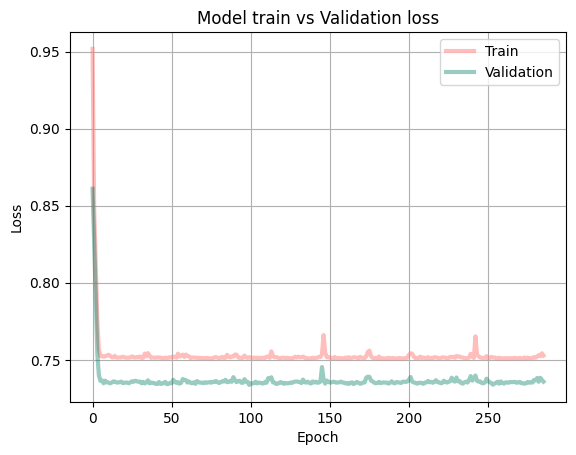

Training loss: 0.7527014017105103
Validation loss: 0.7358264327049255
MSE on training data: 0.017938594508114324
MSE on test data: 0.01804628560783782


Best NMF:
Basis vectors:
 [[0.66246015 0.65458363 0.69620866 ... 0.80187076 0.74983835 0.69573516]]
Coefficients:
 [[0.6161303 ]
 [0.60304064]
 [0.62745124]
 [0.4178965 ]
 [0.63249874]
 [0.5024413 ]
 [0.44133246]
 [0.7132237 ]
 [0.5405441 ]
 [0.4374051 ]
 [0.73666275]
 [0.6412887 ]
 [0.44545493]
 [0.5138878 ]
 [0.6452057 ]
 [0.49764407]
 [0.5048072 ]
 [0.6638508 ]
 [0.7460018 ]
 [0.49657875]
 [0.60738194]
 [0.51666814]
 [0.3290647 ]
 [0.5126593 ]
 [0.60514706]
 [0.57407826]
 [0.5136108 ]
 [0.636934  ]
 [0.6434253 ]
 [0.58393383]
 [0.5925907 ]
 [0.5885031 ]
 [0.7060409 ]
 [0.61928934]
 [0.61381954]
 [0.47386342]
 [0.59913856]
 [0.48303953]
 [0.5180749 ]
 [0.49031243]
 [0.6914438 ]
 [0.671817  ]
 [0.6744924 ]
 [0.5217114 ]
 [0.54886585]
 [0.6772959 ]
 [0.6421645 ]
 [0.5467642 ]
 [0.5557586 ]
 [0.7986782 ]
 [0.5478415 ]
 [0.39249536]
 [0.

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_kernel_pca.py:397: LinAlgWarning: Ill-conditioned matrix (rcond=5.71328e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.0009751598
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161674


Best MSE reconstruction error: 0.0009751598
- Kernel: Linear kernel
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 417)               1215555   
                                                                 
 decoding (Dense)            (None, 2914)              1218052   
                                                                 
Total params: 2433607 (9.28 MB)
Trainable params: 2433607 (9.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


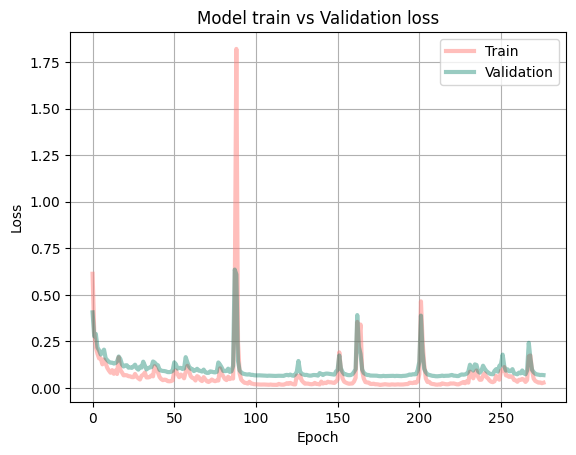

Training loss: 0.02813289687037468
Validation loss: 0.06876455247402191
MSE on training data: 0.0006084606516070936
MSE on test data: 0.0014890136945290681


Best NMF:


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Basis vectors:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00329318 0.01603993 ... 0.         0.         0.        ]
 ...
 [0.03494368 0.06818587 0.04017731 ... 0.18326606 0.12863412 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.02344652 0.01640877 ... 0.         0.         0.        ]]
Coefficients:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [2.3806741  0.         0.02116868 ... 0.06136244 0.         0.        ]
 [0.8835876  0.3389469  0.21954446 ... 0.         0.         0.        ]
 ...
 [1.1335268  0.         0.1517235  ... 0.0881878  0.01344675 0.01809841]
 [0.63528144 0.         0.04543521 ... 0.02676944 0.00815195 0.        ]
 [0.         0.         0.00307528 ... 0.01526431 0.02465524 0.        ]]


Best MSE reconstruction error on train data: 0.0006438343


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Best MSE reconstruction error on test data: 0.0015060828
- MSE loss summary:  lfw is_faces = True k = 417
-- Sparse PCA (alpha= None ): err= 0.0
-- Kernel PCA( Linear kernel ): err= 0.0009751598
-- Autoencoder: err= 0.0014890136945290681
-- NMF: err= 0.0015060828
Number of components: k = 833
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.0004989353
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161579


Best MSE reconstruction error: 0.0004989353
- Kernel: Linear kernel
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 833)               2428195   
                                                                 
 decoding (Dense)            (None, 2914)              2430

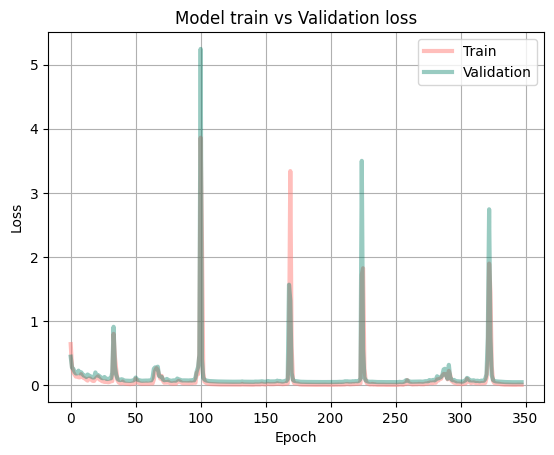

Training loss: 0.0071474239230155945
Validation loss: 0.04710868373513222
MSE on training data: 0.0002278551171496498
MSE on test data: 0.0009993414664057588


Best NMF:


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Basis vectors:
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.1517727e-06 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0330324e-03 4.7143814e-03 1.6903187e-03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 3.6231749e-02 1.8909922e-02 ... 0.0000000e+00
  0.0000000e+00 1.8258041e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.2582519e-02
  3.6518220e-02 0.0000000e+00]
 [0.0000000e+00 2.0640711e-03 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
Coefficients:
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [6.0733926e-01 0.0000000e+00 0.0000000e+00 ... 6.2399898e-02
  0.0000000e+00 0.0000000e+00]
 [7.3190206e-01 1.1394896e-01 2.0472908e-01 ... 0.0000000e+00
  0.0000000e+00 1.2428495e-01]
 ...
 [1.5841042e-01 0.0000000e+00 0.0000000e+00 ... 3.0961998e-02
  0.0000000e+00 2.4963503e-01]
 [2.3676302e+00 1.0276157e+0

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Best MSE reconstruction error on test data: 0.0011940266
- MSE loss summary:  lfw is_faces = True k = 833
-- Sparse PCA (alpha= None ): err= 0.0
-- Kernel PCA( Linear kernel ): err= 0.0004989353
-- Autoencoder: err= 0.0009993414664057588
-- NMF: err= 0.0011940266
Number of components: k = 1249
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.00048700403
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161543


Best MSE reconstruction error: 0.00048700403
- Kernel: Linear kernel
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 1249)              3640835   
                                                                 
 decoding (Dense)            (None, 2914)              3

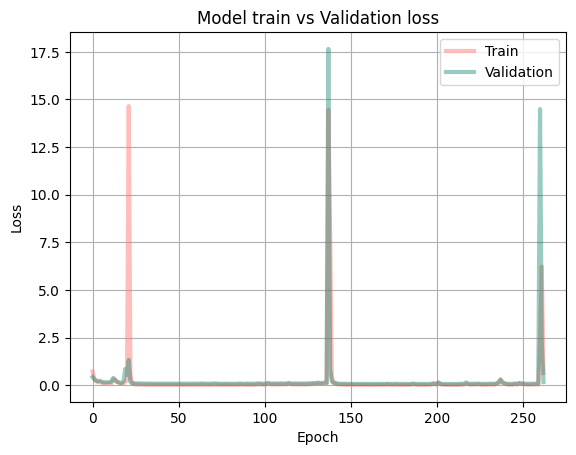

Training loss: 0.6428210139274597
Validation loss: 0.1636088490486145
MSE on training data: 0.0029821305408946367
MSE on test data: 0.0035664992605811525


Best NMF:


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Basis vectors:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00026934 0.00540605 0.         ... 0.         0.         0.        ]
 ...
 [0.03648537 0.         0.         ... 0.04735005 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.0068179  ... 0.         0.         0.        ]]
Coefficients:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [2.3655987  0.5192347  0.         ... 0.         0.         0.        ]
 [3.5343676  1.109572   0.8056971  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.33445302]
 [4.5931244  1.6444905  0.         ... 0.         0.         0.        ]
 [0.         0.02804685 0.         ... 0.         0.         0.28859422]]


Best MSE reconstruction error on train data: 3.6455032e-05


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Best MSE reconstruction error on test data: 0.0010587535
- MSE loss summary:  lfw is_faces = True k = 1249
-- Sparse PCA (alpha= None ): err= 0.0
-- Kernel PCA( Linear kernel ): err= 0.00048700403
-- Autoencoder: err= 0.0035664992605811525
-- NMF: err= 0.0010587535
Number of components: k = 1665
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.00048700403
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161543


Best MSE reconstruction error: 0.00048700403
- Kernel: Linear kernel
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 1665)              4853475   
                                                                 
 decoding (Dense)            (None, 2914)             

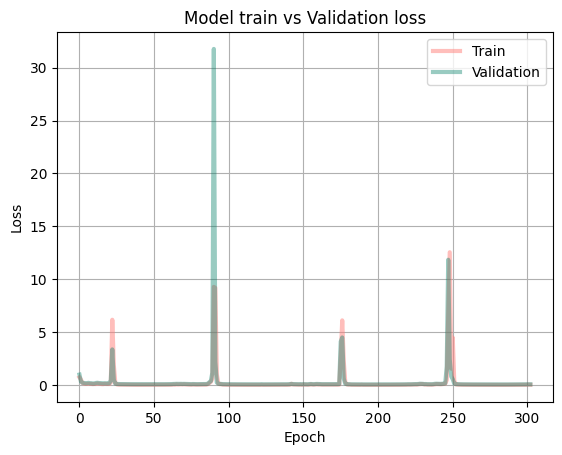

Training loss: 0.024409977719187737
Validation loss: 0.0633760318160057
MSE on training data: 0.0005841041022303985
MSE on test data: 0.0013882204221638396


Best NMF:


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Basis vectors:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00915784 ... 0.         0.         0.        ]]
Coefficients:
 [[0.680174   0.         0.32950845 ... 0.         0.         0.39334488]
 [4.486955   1.1959996  0.38020337 ... 0.         0.         0.        ]
 [6.6028366  2.355131   1.2106526  ... 0.         0.01325689 0.04321718]
 ...
 [1.9132125  0.51123077 0.7425031  ... 0.         0.04252718 0.        ]
 [7.841308   1.8385483  0.47708642 ... 0.         0.         0.        ]
 [1.5718083  0.60518295 0.31578797 ... 0.         0.02034493 0.        ]]


Best MSE reconstruction error on train data: 6.048108e-06


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Best MSE reconstruction error on test data: 0.00091859046
- MSE loss summary:  lfw is_faces = True k = 1665
-- Sparse PCA (alpha= None ): err= 0.0
-- Kernel PCA( Linear kernel ): err= 0.00048700403
-- Autoencoder: err= 0.0013882204221638396
-- NMF: err= 0.00091859046
Number of components: k = 2081
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.00048700403
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161543


Best MSE reconstruction error: 0.00048700403
- Kernel: Linear kernel
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 2081)              6066115   
                                                                 
 decoding (Dense)            (None, 2914)           

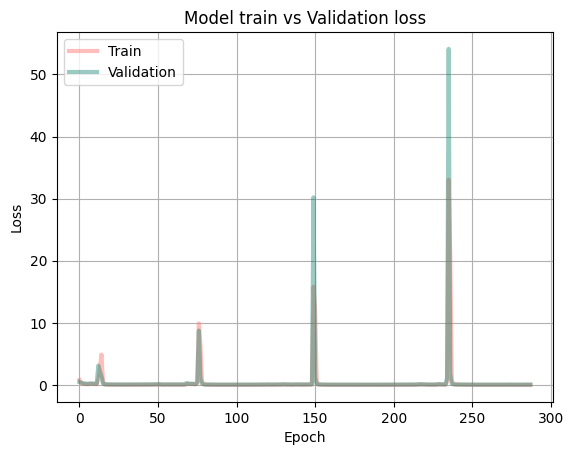

Training loss: 0.01507917232811451
Validation loss: 0.06113309785723686
MSE on training data: 0.00040610692616154854
MSE on test data: 0.0013059132155018901


Best NMF:


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Basis vectors:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.03916903 0.02500083 0.04055245 ... 0.         0.00557735 0.        ]]
Coefficients:
 [[2.9156356  0.24610457 0.7412434  ... 0.         0.         0.        ]
 [8.074683   2.6350088  1.2134907  ... 0.         0.08165    0.        ]
 [8.678294   2.9573789  1.618168   ... 0.00990281 0.         0.        ]
 ...
 [5.8160253  1.8357322  1.6216577  ... 0.20723593 0.         0.        ]
 [8.261809   1.8666283  0.         ... 0.         0.40248242 0.        ]
 [4.2394238  1.542926   0.7755214  ... 0.         0.         0.        ]]


Best MSE reconstruction error on train data: 9.433676e-07


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Best MSE reconstruction error on test data: 0.0007973504
- MSE loss summary:  lfw is_faces = True k = 2081
-- Sparse PCA (alpha= None ): err= 0.0
-- Kernel PCA( Linear kernel ): err= 0.00048700403
-- Autoencoder: err= 0.0013059132155018901
-- NMF: err= 0.0007973504
Number of components: k = 2497
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.00048700403
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161543


Best MSE reconstruction error: 0.00048700403
- Kernel: Linear kernel
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 2497)              7278755   
                                                                 
 decoding (Dense)            (None, 2914)             

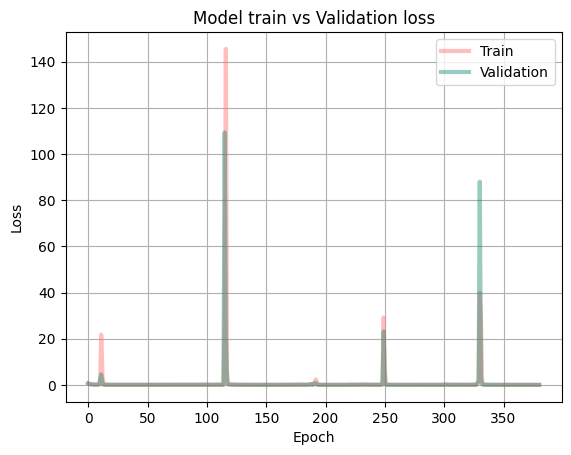

Training loss: 0.010914611630141735
Validation loss: 0.0626705065369606
MSE on training data: 0.00040309263005013025
MSE on test data: 0.001307092938636679


Best NMF:


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Basis vectors:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00265146 ... 0.         0.         0.        ]
 [0.         0.         0.00061198 ... 0.         0.         0.        ]
 ...
 [0.0738749  0.         0.         ... 0.         0.         0.        ]
 [0.00042342 0.         0.01327567 ... 0.0254656  0.01435464 0.03886488]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Coefficients:
 [[3.3675077e+00 3.8201109e-01 1.4410301e+00 ... 1.4625500e-01
  0.0000000e+00 0.0000000e+00]
 [9.1034365e+00 2.8733957e+00 1.0907388e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0626042e+01 3.7999835e+00 1.9971071e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [6.9863720e+00 2.2793739e+00 1.5188049e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0529796e+01 2.4240839e+00 2.0456120e-01 ... 0.0000000e+00
  0.0000000e+00 2.3043029e-01]
 [4.6388297e+00 2.0014093e+00 9.1965985e-01 ... 0.00000

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Best MSE reconstruction error on test data: 0.0006838621
- MSE loss summary:  lfw is_faces = True k = 2497
-- Sparse PCA (alpha= None ): err= 0.0
-- Kernel PCA( Linear kernel ): err= 0.00048700403
-- Autoencoder: err= 0.001307092938636679
-- NMF: err= 0.0006838621
Number of components: k = 2914
Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.00048700403
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161543


Best MSE reconstruction error: 0.00048700403
- Kernel: Linear kernel
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 2914)              8494310   
                                                                 
 decoding (Dense)            (None, 2914)              

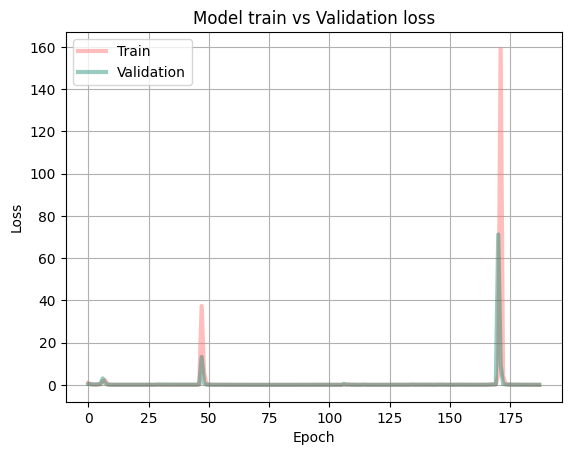

Training loss: 0.03417547419667244
Validation loss: 0.07899566739797592
MSE on training data: 0.0008039269512651745
MSE on test data: 0.0017457217266919093


Best NMF:


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Basis vectors:
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 7.8327162e-03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 8.3222176e-06 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.8237216e-03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 7.2870515e-03 ... 0.0000000e+00
  1.0438408e-03 0.0000000e+00]]
Coefficients:
 [[4.53490448e+00 7.27626801e-01 1.76786768e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.09991875e+01 3.75552225e+00 1.37865388e+00 ... 4.38129306e-02
  7.39225522e-02 0.00000000e+00]
 [1.18454485e+01 4.18134594e+00 1.98081398e+00 ... 1.94952288e-03
  4.40535881e-02 0.00000000e+00]
 ...
 [9.49942112e+00 3.38979554e+00 1.84760344e+00 ... 2.68243849e-02
  8.93278702e-05 0.00000000e+00]
 [1.

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [14]:
# Run LFW test sweep, TODO: DON'T SKIP SPCA!
res=run_test_sweep(num_dataset_dims, X_train, X_test, is_faces=True, dataset_name=dataset_name, h=h, w=w, skip_spca_for_faces=True, no_sigmoid=True)

Filename: results_lfw.p


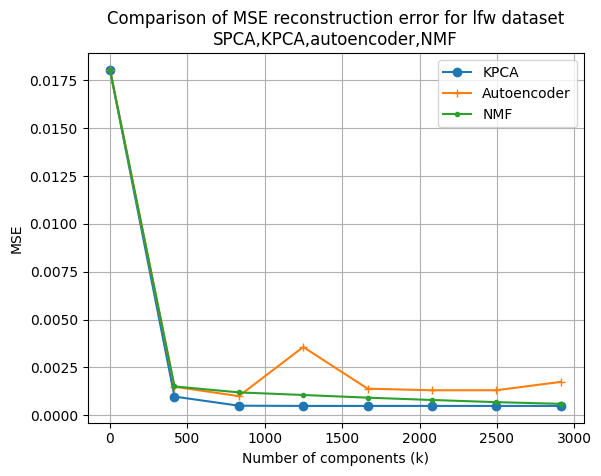

In [17]:
# Reload the test data which was just saved
fn_prefix="results_"
fn=fn_prefix+dataset_name+".p"
print("Filename:",fn)
res_loaded={}
with open(fn,"rb") as fp:
    res_loaded = pickle.load(fp)

k_spca,loss_spca=res_query(res_loaded,model="spca")
k_kpca,loss_kpca=res_query(res_loaded,model="kpca")
k_autoencoder,loss_autoencoder=res_query(res_loaded,model="autoencoder")
k_nmf,loss_nmf=res_query(res_loaded,model="nmf")

# Plot comparison
#plt.plot(k_spca,loss_spca,"x-")
plt.plot(k_kpca,loss_kpca,"o-")
plt.plot(k_autoencoder,loss_autoencoder,"+-")
plt.plot(k_nmf,loss_nmf,".-")
plt.grid('on')
plt.xlabel('Number of components (k)')
plt.ylabel('MSE')
plt.title('Comparison of MSE reconstruction error for '+dataset_name+' dataset\nSPCA,KPCA,autoencoder,NMF')
#plt.legend(["SPCA","KPCA","Autoencoder","NMF"])
plt.legend(["KPCA","Autoencoder","NMF"])